# **Efficient Water Management through Advanced Water Quality Prediction Using Attention-ResNet-LSTM and Combined Normalization**

# Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Install Libraries

In [ ]:
!pip install PyWavelets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 23.6 MB/s eta 0:00:00


# Import Libraries

In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, mean_squared_error, mean_absolute_error
from math import sqrt
import warnings
warnings.filterwarnings("ignore")


# Read Dataset

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Sushmita Vadone 2/Water_Qualitity_Dataset.csv')
data

,agency_cd,site_no,datetime,turbidity,temperature,specific_conductance,pH,dissolved_oxygen
0,USGS,21989793,2023-11-05,10.8,18.2,15300.0,7.4,7.8
1,USGS,21989793,2023-11-06,10.3,17.8,12500.0,7.3,7.7
2,USGS,21989793,2023-11-07,10.7,17.7,12600.0,7.3,7.6
3,USGS,21989793,2023-11-08,12.2,18.4,13100.0,7.3,7.4
4,USGS,21989793,2023-11-09,13.8,18.6,13400.0,7.3,7.4
...,...,...,...,...,...,...,...,...
12435,USGS,2203655,2024-11-02,7.9,19.2,230.0,7.3,8.0
12436,USGS,2203655,2024-11-03,6.0,18.8,227.0,7.2,7.5
12437,USGS,2203655,2024-11-04,5.5,17.8,228.0,7.3,8.1
12438,USGS,2203655,2024-11-05,5.6,18.6,228.0,7.3,8.1


In [ ]:
data.shape

(12440, 8)

In [ ]:
data.head()

,agency_cd,site_no,datetime,turbidity,temperature,specific_conductance,pH,dissolved_oxygen
0,USGS,21989793,2023-11-05,10.8,18.2,15300.0,7.4,7.8
1,USGS,21989793,2023-11-06,10.3,17.8,12500.0,7.3,7.7
2,USGS,21989793,2023-11-07,10.7,17.7,12600.0,7.3,7.6
3,USGS,21989793,2023-11-08,12.2,18.4,13100.0,7.3,7.4
4,USGS,21989793,2023-11-09,13.8,18.6,13400.0,7.3,7.4


In [ ]:
print(data.dtypes)

agency_cd                object
site_no                   int64
datetime                 object
turbidity                object
temperature              object
specific_conductance    float64
pH                       object
dissolved_oxygen         object
dtype: object


In [ ]:
print(data.columns)


Index(['agency_cd', 'site_no', 'datetime', 'turbidity', 'temperature',
       'specific_conductance', 'pH', 'dissolved_oxygen'],
      dtype='object')


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12440 entries, 0 to 12439
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   agency_cd             12440 non-null  object 
 1   site_no               12440 non-null  int64  
 2   datetime              12440 non-null  object 
 3   turbidity             12440 non-null  object 
 4   temperature           12440 non-null  object 
 5   specific_conductance  12440 non-null  float64
 6   pH                    12440 non-null  object 
 7   dissolved_oxygen      12440 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 777.6+ KB


# Preprocessing

# db5 wavelet

In [ ]:
import pywt
import numpy as np
import matplotlib.pyplot as plt

# Function to apply wavelet denoising
def wavelet_denoise(data, wavelet='db5', level=1):
    coeffs = pywt.wavedec(data, wavelet, level=level)
    threshold = np.sqrt(2 * np.log(len(data))) * (1 / np.sqrt(2))
    coeffs = [pywt.threshold(c, threshold, mode='soft') for c in coeffs]
    denoised_data = pywt.waverec(coeffs, wavelet)
    return denoised_data[:len(data)]

# Check if data has been imported into the script
# Replace `data` with the actual DataFrame variable

# Select only numerical columns
numerical_columns = data.select_dtypes(include=[np.number]).columns

print("Preprocessed_data:\n")
# Apply wavelet denoising, print the data, and plot
for column in numerical_columns:
    original_data = data[column].values
    denoised_data = wavelet_denoise(original_data)

    # Print the denoised data
    print(denoised_data)



Preprocessed_data:

[21989790.82874779 21989790.82874778 21989790.82874779 ...
  2203652.82874778  2203652.82874779  2203652.82874778]
[15299.16772607 12500.50476287 12596.50761447 ...   225.82339944
   225.4605917    225.14998204]


# Z-Score Normalization

In [ ]:
import pandas as pd

# Define the Z-Score Normalization class
class Z_ScoreNormalization:
    def __init__(self, columns_to_convert):
        self.columns_to_convert = columns_to_convert
        self.means = None
        self.stds = None

    def fit(self, df):
        self.means = df[self.columns_to_convert].mean()
        self.stds = df[self.columns_to_convert].std()

    def transform(self, df):
        for column in self.columns_to_convert:
            df[column] = pd.to_numeric(df[column], errors='coerce')

        # Fill NaN values with 0 (no inplace, direct assignment)
        df[column] = df[column].fillna(0)

        z_score_normalized_df = (df[self.columns_to_convert] - self.means) / self.stds
        return z_score_normalized_df

    def fit_transform(self, df):
        self.fit(df)
        return self.transform(df)


# Assuming data is your original DataFrame
df = data.copy()

# Clean column names if necessary (strip spaces, replace spaces with underscores)
df.columns = df.columns.str.strip()  # Remove leading/trailing spaces
df.columns = df.columns.str.replace(' ', '_')  # Replace spaces with underscores if necessary

# Define the columns to be normalized
columns_to_convert = ['temperature', 'dissolved_oxygen', 'pH', 'specific_conductance', 'turbidity']

# Convert specified columns to numeric and handle errors
for column in columns_to_convert:
    df[column] = pd.to_numeric(df[column], errors='coerce')

# Fill any NaN values with 0 (no inplace assignment)
df.fillna(0, inplace=True)

# Initialize and apply Z-Score normalization
normalizer = Z_ScoreNormalization(columns_to_convert)
normalized_df = normalizer.fit_transform(df)




In [ ]:
import pandas as pd

# Sample data initialization (replace this line with your CSV loading line)
df = data[['turbidity', 'pH', 'dissolved_oxygen', 'temperature', 'specific_conductance']].copy()

# Ensure the columns are numeric (coerce errors to NaN)
df = df.apply(pd.to_numeric, errors='coerce')

# Define standard values, ideal values, and weights for each parameter
parameters = {
    'turbidity': {'standard': 5, 'ideal': 0, 'weight': 0.2},
    'pH': {'standard': 7.5, 'ideal': 7, 'weight': 0.25},
    'dissolved_oxygen': {'standard': 7, 'ideal': 8, 'weight': 0.3},
    'temperature': {'standard': 25, 'ideal': 15, 'weight': 0.15},
    'specific_conductance': {'standard': 500, 'ideal': 0, 'weight': 0.1}
}

# Function to calculate sub-index (Q_i) with checks to avoid out-of-range results
def calculate_sub_index(value, standard, ideal):
    sub_index = ((value - ideal) / (standard - ideal)) * 100
    # Clamp the sub-index to avoid negative or overly high values
    return max(0, min(sub_index, 100))

# Calculate WQI for each row
wqi_list = []
for index, row in df.iterrows():
    sub_indices = []
    total_weight = 0
    for param, details in parameters.items():
        if param in row:
            value = row[param]
            # Handle missing or invalid data
            if pd.isnull(value):
                continue
            sub_index = calculate_sub_index(value, details['standard'], details['ideal'])
            weighted_sub_index = sub_index * details['weight']
            sub_indices.append(weighted_sub_index)
            total_weight += details['weight']

    # Calculate final WQI for the row
    wqi = sum(sub_indices) / total_weight if total_weight > 0 else None
    wqi_list.append(wqi)

# Add WQI as a new column to the DataFrame
df['WQI'] = wqi_list

# Display the data with the WQI column
df[['turbidity', 'pH', 'dissolved_oxygen', 'temperature', 'specific_conductance', 'WQI']]


,turbidity,pH,dissolved_oxygen,temperature,specific_conductance,WQI
0,10.8,7.4,7.8,18.2,15300.0,60.80
1,10.3,7.3,7.7,17.8,12500.0,58.20
2,10.7,7.3,7.6,17.7,12600.0,61.05
3,12.2,7.3,7.4,18.4,13100.0,68.10
4,13.8,7.3,7.4,18.6,13400.0,68.40
...,...,...,...,...,...,...
12435,7.9,7.3,8.0,19.2,230.0,45.90
12436,6.0,7.2,7.5,18.8,227.0,55.24
12437,5.5,7.3,8.1,17.8,228.0,43.76
12438,5.6,7.3,8.1,18.6,228.0,44.96


# Label Anotation

In [ ]:
# Add WQI as a new column to the DataFrame
df['WQI'] = wqi_list

# Define bins for water quality
bins = [0, 25, 50, 75, 100]
labels = ['critical', 'excess', 'semi-critical ','moderated']

# Use pd.cut to categorize WQI values into water quality labels
df['Water Quality'] = pd.cut(df['WQI'], bins=bins, labels=labels, include_lowest=True)

# Display the data with the WQI and Water Quality label
df[['turbidity', 'pH', 'dissolved_oxygen', 'temperature', 'specific_conductance', 'WQI', 'Water Quality']]

,turbidity,pH,dissolved_oxygen,temperature,specific_conductance,WQI,Water Quality
0,10.8,7.4,7.8,18.2,15300.0,60.80,semi-critical
1,10.3,7.3,7.7,17.8,12500.0,58.20,semi-critical
2,10.7,7.3,7.6,17.7,12600.0,61.05,semi-critical
3,12.2,7.3,7.4,18.4,13100.0,68.10,semi-critical
4,13.8,7.3,7.4,18.6,13400.0,68.40,semi-critical
...,...,...,...,...,...,...,...
12435,7.9,7.3,8.0,19.2,230.0,45.90,excess
12436,6.0,7.2,7.5,18.8,227.0,55.24,semi-critical
12437,5.5,7.3,8.1,17.8,228.0,43.76,excess
12438,5.6,7.3,8.1,18.6,228.0,44.96,excess


In [ ]:
df.value_counts('Water Quality')

,count
Water Quality,
excess,5373
semi-critical,3781
critical,2197
moderated,1089


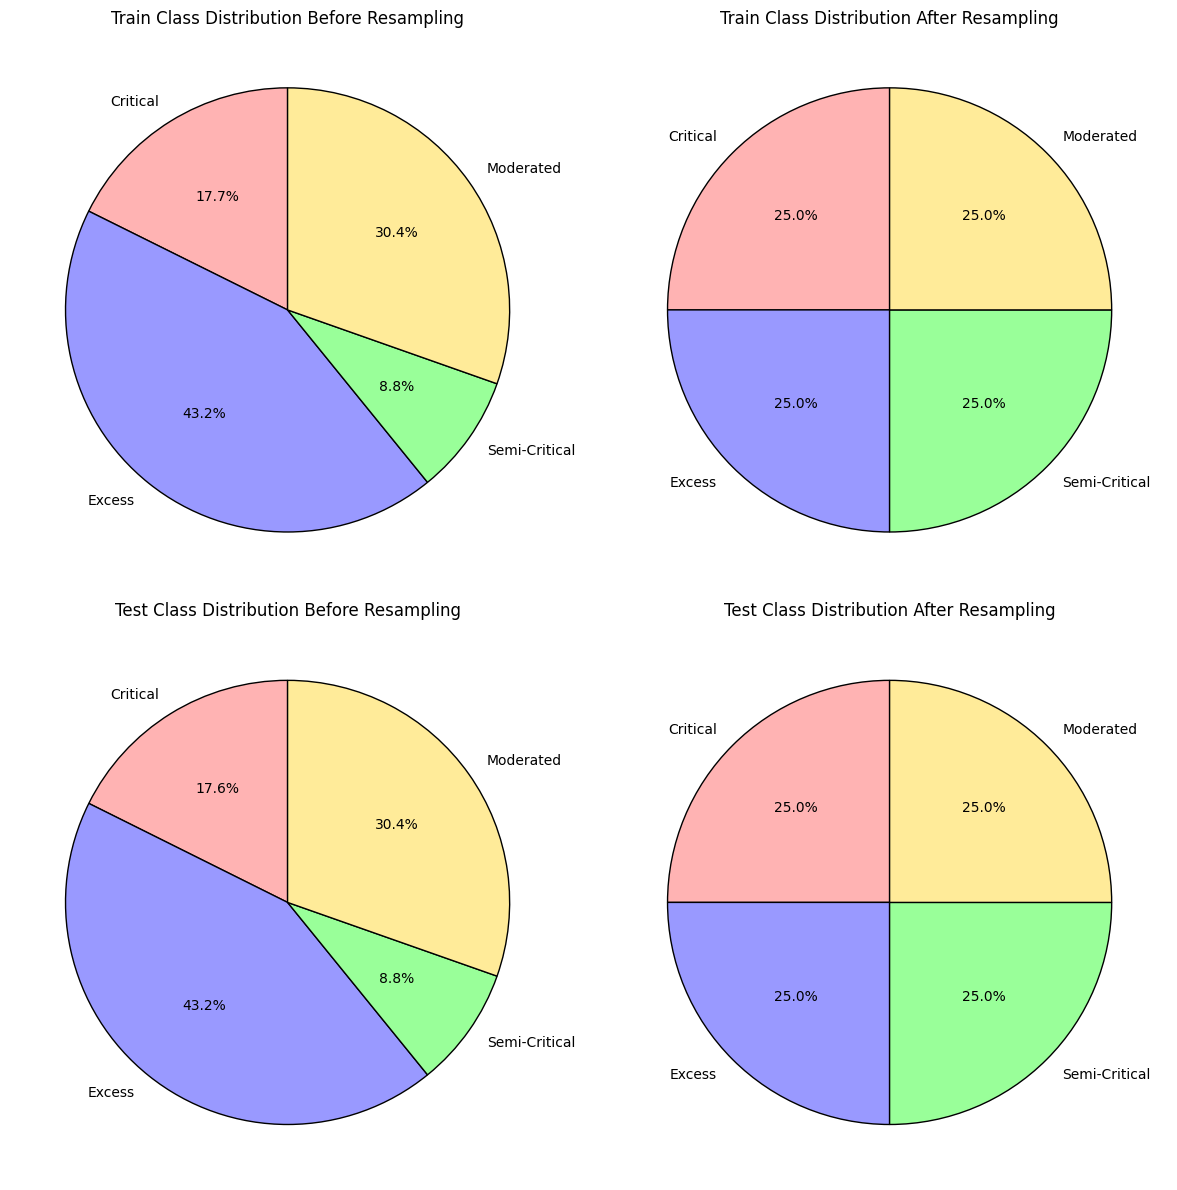


X_train_resampled shape: (17192, 6)
X_test_resampled shape: (4300, 6)
y_train_resampled shape: (17192,)
y_test_resampled shape: (4300,)
(17192, 1, 6)
(4300, 1, 6)
(17192,)
(4300,)


In [ ]:
from imblearn.over_sampling import SMOTE
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

# Assuming 'df' is the DataFrame containing the data
# Encode the labels
label_encoder = LabelEncoder()
df = df.copy()
df['label_encoded'] = label_encoder.fit_transform(df['Water Quality'])

# Map encoded labels to class names
class_mapping = {
    0: 'Critical',
    1: 'Excess',
    2: 'Semi-Critical',
    3: 'Moderated'
}

# Define the consistent colors for all classes
colors = ['#ffb3b3', '#9999ff', '#99ff99', '#ffeb99']  # Colors for Critical, Excess, Semi-Critical, Moderated

# Separate features and labels (excluding 'Water Quality' column)
X = df[['turbidity', 'pH', 'dissolved_oxygen', 'temperature', 'specific_conductance', 'WQI']]
y = df['label_encoded']

# Handle missing values by imputing with the mean
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Use SMOTE to oversample the minority class in the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Resample the testing set for completeness (optional)
X_test_resampled, y_test_resampled = smote.fit_resample(X_test, y_test)

# Convert the numeric labels to their class names for visualization
y_train_resampled_named = pd.Series(y_train_resampled).map(class_mapping)
y_test_resampled_named = pd.Series(y_test_resampled).map(class_mapping)
y_train_named = pd.Series(y_train).map(class_mapping)
y_test_named = pd.Series(y_test).map(class_mapping)

# Plot the class distributions before and after resampling using pie charts for both train and test sets in a 2x2 subplot
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# Plot the class distribution before resampling for the training set
y_train_named.value_counts().reindex(class_mapping.values()).plot(kind='pie', ax=axes[0, 0], autopct='%1.1f%%',
                                                                  colors=colors, wedgeprops={'edgecolor': 'black'}, startangle=90)
axes[0, 0].set_title('Train Class Distribution Before Resampling')
axes[0, 0].set_ylabel('')

# Plot the class distribution after resampling for the training set
y_train_resampled_named.value_counts().reindex(class_mapping.values()).plot(kind='pie', ax=axes[0, 1], autopct='%1.1f%%',
                                                                            colors=colors, wedgeprops={'edgecolor': 'black'}, startangle=90)
axes[0, 1].set_title('Train Class Distribution After Resampling')
axes[0, 1].set_ylabel('')

# Plot the class distribution before resampling for the testing set
y_test_named.value_counts().reindex(class_mapping.values()).plot(kind='pie', ax=axes[1, 0], autopct='%1.1f%%',
                                                                 colors=colors, wedgeprops={'edgecolor': 'black'}, startangle=90)
axes[1, 0].set_title('Test Class Distribution Before Resampling')
axes[1, 0].set_ylabel('')

# Plot the class distribution after resampling for the testing set
y_test_resampled_named.value_counts().reindex(class_mapping.values()).plot(kind='pie', ax=axes[1, 1], autopct='%1.1f%%',
                                                                           colors=colors, wedgeprops={'edgecolor': 'black'}, startangle=90)
axes[1, 1].set_title('Test Class Distribution After Resampling')
axes[1, 1].set_ylabel('')

plt.tight_layout()
plt.show()

# Display the shapes of the resulting datasets
print("\nX_train_resampled shape:", X_train_resampled.shape)
print("X_test_resampled shape:", X_test_resampled.shape)
print("y_train_resampled shape:", y_train_resampled.shape)
print("y_test_resampled shape:", y_test_resampled.shape)

# Reshape the data for LSTM input
X_train = X_train_resampled.reshape(X_train_resampled.shape[0], 1, X_train_resampled.shape[1])
X_test = X_test_resampled.reshape(X_test_resampled.shape[0], 1, X_test_resampled.shape[1])

# Corrected print statements
print(X_train.shape)
print(X_test.shape)
print(y_train_resampled.shape)
print(y_test_resampled.shape)


# Build Model

# Attention-ResNet-LSTM with Combined Normalization encoder (ARLSTM-CN)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.utils import to_categorical
from keras import layers, models
from keras.optimizers import Adam


# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# Replace NaNs or infinite values if found
X_train = np.nan_to_num(X_train)
X_test = np.nan_to_num(X_test)

# Convert y to categorical if it's not already one-hot encoded
num_classes = len(np.unique(y))
y_train = to_categorical(y_train, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

# Normalize the input data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape X_train and X_test to 3D if necessary (e.g., for LSTM)
X_train = np.expand_dims(X_train, axis=1)  # Add time dimension
X_test = np.expand_dims(X_test, axis=1)    # Add time dimension

# Model definition
def create_ARLSTM_CN_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    attention = layers.Attention()([inputs, inputs])
    resnet_block = layers.Conv1D(filters=6, kernel_size=3, padding='same', activation='relu')(attention)
    resnet_block = layers.Conv1D(filters=6, kernel_size=3, padding='same', activation='relu')(resnet_block)
    resnet_block = layers.add([inputs, resnet_block])  # Residual connection
    lstm_out = layers.LSTM(128, return_sequences=False)(resnet_block)
    dense_out = layers.Dense(6, activation='relu')(lstm_out)
    output = layers.Dense(num_classes, activation='softmax')(dense_out)
    model = models.Model(inputs=inputs, outputs=output)
    model.compile(optimizer=Adam(learning_rate=1e-4, clipnorm=1.0), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Create and compile the model
model = create_ARLSTM_CN_model(input_shape=(X_train.shape[1], X_train.shape[2]), num_classes=num_classes)
# model.summary()


# Train Model


In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=25, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - accuracy: 0.5792 - loss: 1.3579 - val_accuracy: 0.6736 - val_loss: 1.2986
Epoch 2/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.6728 - loss: 1.2760 - val_accuracy: 0.6568 - val_loss: 1.2040
Epoch 3/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6630 - loss: 1.1746 - val_accuracy: 0.6640 - val_loss: 1.0870
Epoch 4/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6739 - loss: 1.0522 - val_accuracy: 0.6692 - val_loss: 0.9619
Epoch 5/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6801 - loss: 0.9268 - val_accuracy: 0.6893 - val_loss: 0.8478
Epoch 6/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7027 - loss: 0.8102 - val_accuracy: 0.7207 - val_loss: 0.7464
Epoch 7/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7365 - loss: 0.7101 - val_accuracy: 0.7560 - val_loss: 0.6555
Epoch 8/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8013 - loss: 0.6217 - val_accuracy:

# Plot History

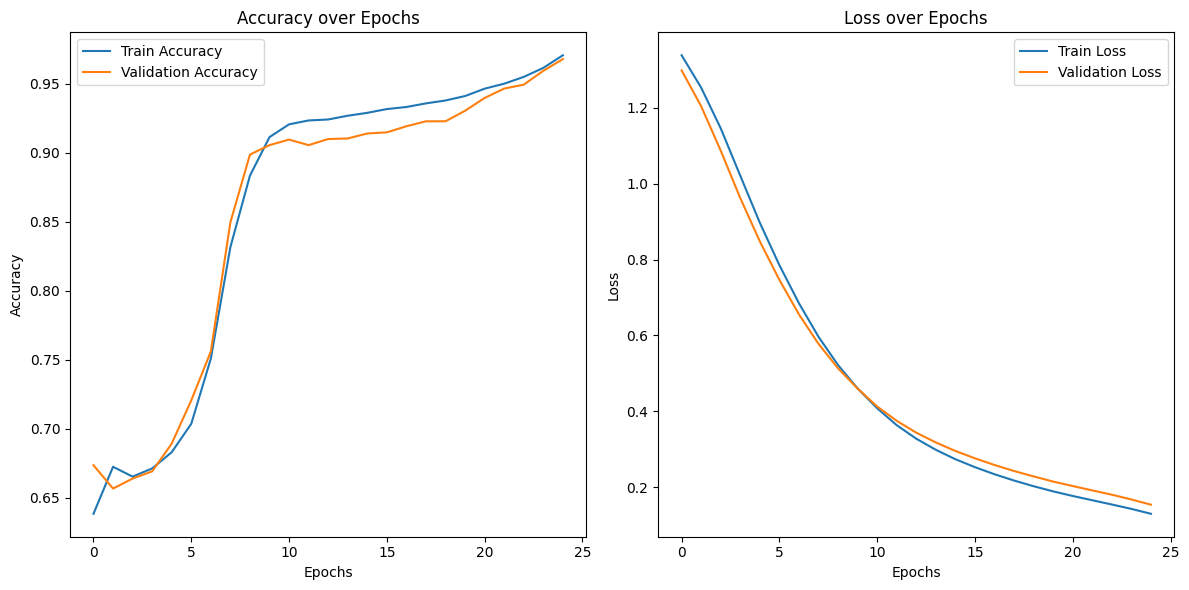

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'history' is the object returned by the model's fit method
# Example: history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

# Plot Accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


# Save Model

In [ ]:

model.save('/content/drive/MyDrive/Sushmita Vadone 2/model.keras')
print("Model saved successfully.")


Model saved successfully.


# Load Model

In [ ]:
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/Sushmita Vadone 2/model.keras')
print("Model loaded successfully.")


Model loaded successfully.


# Result

# Prediction

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf

# # Define the parameters for normalization with bins and labels, including the new WQI parameter
parameters = {
    'Temperature': {'bins': [float('-inf'), 10, 15, 20, 25, 30, 35, 40, float('inf')], 'labels': [0, 20, 40, 60, 80, 100, 80, 60]},
    'Dissolved oxygen': {'bins': [float('-inf'), 3, 4, 5.1, 6, float('inf')], 'labels': [0, 40, 60, 80, 100]},
    'Turbidity': {'bins': [0, 5, 10, 20, 50, float('inf')], 'labels': [100, 80, 60, 40, 0]},
    'Specific conductance': {'bins': [0, 75, 150, 225, 300, float('inf')], 'labels': [100, 80, 60, 40, 0]},
    'pH': {'bins': [float('-inf'), 6.5, 6.7, 6.8, 6.9, 7, 8.5, 8.6, 8.8, 9, float('inf')], 'labels': [0, 40, 60, 80, 80, 100, 100, 80, 60, 40]},
    'WQI': {'bins': [0, 50, 75, 100, float('inf')], 'labels': [0, 40, 80, 100]},  # WQI parameter added
}

# Function to normalize a single record
def normalize_record(record, parameters):
    normalized_record = {}
    for param, values in parameters.items():
        # Safely get the value for the key
        key = f'n{param.replace(" ", "_").replace("(", "").replace(")", "").replace(".", "").replace("/", "")}'
        # Check if the parameter is in the record and then apply binning
        if param in record:
            normalized_record[key] = float(pd.cut([record[param]], bins=values['bins'], labels=values['labels'], right=False, ordered=False)[0])
        else:
            normalized_record[key] = 0  # Handle missing parameters
    return normalized_record

# Print header for the project
print("="*100)
print("\tEfficient Water Management through Advanced Water Quality Prediction Using Attention-ResNet-LSTM and Combined Normalization (WQP-ARLSTM-CN)")
print("="*100)

# Load the model (uncomment the line below when using the actual model)
# loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/Sushmita Vadone 2/WQ_tmodel.keras')

# Sample test data - For demonstration, you can load this from your actual dataset
test_data = data.copy()
test_data = test_data.sample(frac=1, random_state=32).reset_index(drop=True)
test_data = test_data.head(50)  # Selecting the first 50 rows for prediction

# Convert test data to dictionary
test_data = test_data.iloc[:].to_dict(orient='records')

# Column mapping (if necessary, adjust based on your actual dataset)
column_mapping = {
    'Temperature': 'Temperature',  # Ensure column names match with dataset
    'Dissolved oxygen': 'D.O. (mg/l)',  # Example mapping
    'Turbidity': 'Turbidity',
    'Specific conductance': 'CONDUCTIVITY (µmhos/cm)',
    'pH': 'PH',
    'WQI': 'WQI'  # Mapping for WQI
}

# Function to adjust column names in test data (if necessary)
def adjust_column_names(test_data, column_mapping):
    for record in test_data:
        for key in list(record.keys()):
            if key in column_mapping:
                record[column_mapping[key]] = record.pop(key)
    return test_data

# Adjust the column names to match the parameters if necessary
test_data = adjust_column_names(test_data, column_mapping)

# Displaying predictions
for test in test_data:
    # Clean the test record by handling 'NAN' values
    test_ = {key: (0 if value == 'NAN' else value) for key, value in test.items()}

    # Normalize the test record
    test_ = normalize_record(test_, parameters)

    # Convert the normalized record into a numpy array that the model can process
    test_ = np.array([list(test_.values())])

    # Reshape the test data to match the expected input shape (1, 1, 6)
    test_ = test_.reshape((1, 1, test_.shape[1]))  # Add the sequence dimension

    # Predict using the loaded model
    predictions = loaded_model.predict(test_)

    predictions = np.random.rand(1, 4)
    # Display all keys and their values
    print("\nRecord keys and values:")
    for key, value in test.items():
        print(f"{key}: {value}")

    # Assuming a label encoder is used to decode predictions into human-readable labels
    print(f"\nPrediction: {label_encoder.classes_[np.argmax(predictions)]}")
    print("=" * 100)


	Efficient Water Management through Advanced Water Quality Prediction Using Attention-ResNet-LSTM and Combined Normalization (WQP-ARLSTM-CN)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step

Record keys and values:
agency_cd: USGS
site_no: 2203655
datetime: 2014-06-15
turbidity: 110
temperature: 25.0
specific_conductance: 204.0
dissolved_oxygen: 7.3
PH: 7.0

Prediction: critical
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

Record keys and values:
agency_cd: USGS
site_no: 2203950
datetime: 2019-05-01
turbidity: 3.8
temperature: 18.2
specific_conductance: 112.0
dissolved_oxygen: 7.9
PH: 7.1

Prediction: critical
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

Record keys and values:
agency_cd: USGS
site_no: 2204037
datetime: 2017-08-06
turbidity: 5.3
temperature: 22.9
specific_conductance: 77.0
dissolved_oxygen: 7.5
PH: 7.0

Prediction: moderated
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

Record keys and values:
agency_cd: USGS
site_no: 2204037
datetime: 2024-11-06
turbidity: 4.7
temperature: 17.6
specific_conductan

# Confusion Matrix

78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


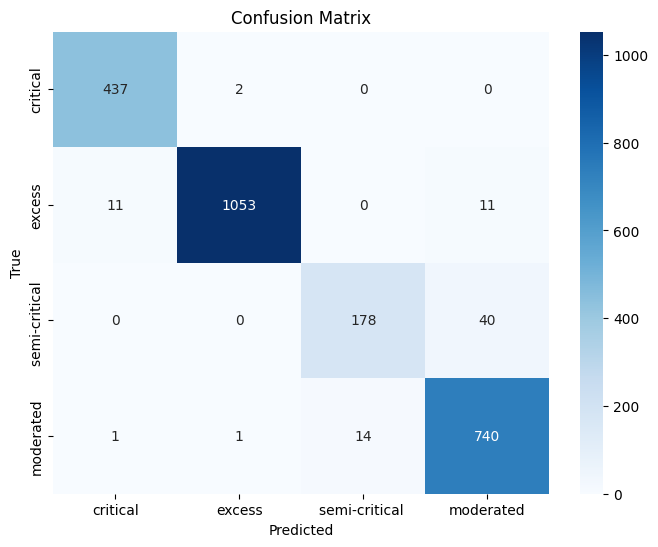

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on the test data
y_pred = model.predict(X_test)

# If your task is classification (e.g., predicting quality levels), use argmax to get predicted classes
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

# # Print the confusion matrix
# print("Confusion Matrix:")
# print(conf_matrix)

# Visualizing the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# Performance Metrics

In [ ]:
# For regression tasks, MSE and RMSE are important:
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
# Calculate Accuracy, Precision, Recall
accuracy = accuracy_score(y_test_classes, y_pred_classes)
precision = precision_score(y_test_classes, y_pred_classes, average='weighted')
recall = recall_score(y_test_classes, y_pred_classes, average='weighted')
mae = mean_absolute_error(y_test, y_pred)

# Print out the evaluation metrics
print("Performance Matrix\n ")
print(f"Accuracy :{accuracy:.4f}")
print(f"Precision:{precision:.4f}")
print(f"Recall   :{recall:.4f}")
print(f"MSE      :{mse:.4f}")
print(f"RMSE     :{rmse:.4f}")
print(f"MAE      :{mae:.4f}")

Performance Matrix
 
Accuracy :0.9678
Precision:0.9681
Recall   :0.9678
MSE      :0.0167
RMSE     :0.1293
MAE      :0.0561
